In [1]:
!pip install faiss-cpu
!pip -q install sentence-transformers
!pip -q install google-generativeai
!pip -q install deepeval

import os
import re
import pandas as pd

import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import faiss
from sentence_transformers import SentenceTransformer, CrossEncoder
from google.colab import userdata
import google.generativeai as genai


In [2]:
kaggle_json_path = "kaggle.json" # import into directory

!mkdir -p ~/.kaggle

if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError(
        "kaggle.json not found in current directory. "
        "Download it from Kaggle → Account → API → Create Token"
    )

!cp {kaggle_json_path} ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API setup complete")


!mkdir -p ./data/twitter
!mkdir -p ./data/reddit
!mkdir -p ./data/news

print("Data directories created")

!kaggle datasets download \
    -d alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects \
    --unzip \
    -p ./data/reddit

print("Reddit dataset downloaded\n")


!kaggle datasets download \
    -d kazanova/sentiment140 \
    --unzip \
    -p ./data/twitter

print("Twitter (Sentiment140) dataset downloaded\n")


!kaggle datasets download \
    -d rmisra/news-category-dataset \
    --unzip \
    -p ./data/news

print("News dataset downloaded\n")



Kaggle API setup complete
Data directories created
Dataset URL: https://www.kaggle.com/datasets/alyahmedts13/reddit-sentiment-analysis-dataset-for-nlp-projects
License(s): apache-2.0
  0% 0.00/1.15M [00:00<?, ?B/s]
100% 1.15M/1.15M [00:00<00:00, 233MB/s]
Reddit dataset downloaded

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
  0% 0.00/80.9M [00:00<?, ?B/s]
100% 80.9M/80.9M [00:00<00:00, 858MB/s]
Twitter (Sentiment140) dataset downloaded

Dataset URL: https://www.kaggle.com/datasets/rmisra/news-category-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/26.5M [00:00<?, ?B/s]
100% 26.5M/26.5M [00:00<00:00, 350MB/s]
News dataset downloaded



In [3]:
# aggregating datasets together

def build_artist_patterns(artists_and_aliases: dict) -> dict:
    def alias_to_pattern(alias: str) -> str:
        parts = re.split(r"\s+", alias.strip().lower())
        # allow punctuation/hyphens/spaces between words
        return r"\b" + r"(?:\W+)".join(map(re.escape, parts)) + r"\b"

    patterns = {}
    for artist, aliases in artists_and_aliases.items():
        aliases = sorted(set(aliases), key=len, reverse=True)
        patt = "|".join(alias_to_pattern(a) for a in aliases)
        patterns[artist] = re.compile(patt, flags=re.IGNORECASE)
    return patterns

# finds the matches artists given a text
def match_artists(text: str, artist_patterns: dict) -> list:
    if not isinstance(text, str):
        return []
    hits = []
    for artist, patt in artist_patterns.items():
        if patt.search(text):
            hits.append(artist)
    return hits

# loads all the datasets into one aggregate schema - returns all_df and artist_df
def aggregate_public_perception_data(
    twitter_csv_path: str = "./data/twitter/training.1600000.processed.noemoticon.csv",
    reddit_csv_path: str = "./data/reddit/reddit_artist_posts_sentiment.csv",
    news_json_path: str = "./data/news/News_Category_Dataset_v3.json",
    artists_and_aliases: dict | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame]:

    artist_patterns = build_artist_patterns(artists_and_aliases)

    # twitter columns = ["target", "ids", "date", "flag", "user", "text"]
    tw_cols = ["target", "ids", "date", "flag", "user", "text"]
    twitter = pd.read_csv(
        twitter_csv_path,
        encoding="latin-1",
        header=None,
        names=tw_cols,
        usecols=tw_cols,
    )

    # map sentiment140: 0 neg, 2 neu, 4 pos
    target_map = {0: "negative", 2: "neutral", 4: "positive"}
    twitter["sentiment_label"] = twitter["target"].map(target_map).fillna("unknown")
    twitter["date"] = pd.to_datetime(twitter["date"], errors="coerce", utc=True)

    twitter_std = pd.DataFrame({
        "source": "twitter",
        "id": twitter["ids"].astype(str),
        "date": twitter["date"],
        "category": pd.NA,
        "title": pd.NA,
        "text": twitter["text"].astype(str),
        "url": pd.NA,
        "author": twitter["user"].astype(str),
        "sentiment_label": twitter["sentiment_label"],
        "sentiment_score": twitter["target"].map({0: -1.0, 2: 0.0, 4: 1.0}),
    })

    # Reddit columns: text, label
    reddit = pd.read_csv(reddit_csv_path)

    if "text" not in reddit.columns:
        raise ValueError(f"Reddit CSV must contain 'text'. Found: {reddit.columns.tolist()}")

    # Normalize label to {negative, neutral, positive}
    def normalize_reddit_label(x):
        if pd.isna(x):
            return "unknown"
        s = str(x).strip().lower()
        if s in {"neg", "negative", "-1"}:
            return "negative"
        if s in {"neu", "neutral", "0"}:
            return "neutral"
        if s in {"pos", "positive", "1"}:
            return "positive"
        if s == "2":
            return "positive"
        return s

    if "label" in reddit.columns:
        reddit_sent = reddit["label"].apply(normalize_reddit_label)
    else:
        reddit_sent = pd.Series(["unknown"] * len(reddit))

    reddit_std = pd.DataFrame({
        "source": "reddit",
        "id": reddit.index.astype(str),
        "date": pd.NaT,
        "category": pd.NA,
        "title": pd.NA,
        "text": reddit["text"].astype(str),
        "url": pd.NA,
        "author": pd.NA,
        "sentiment_label": reddit_sent,
        "sentiment_score": pd.NA,
    })

    # News columns: category, headline, authors, link, short_description, date
    news = pd.read_json(news_json_path, lines=True)

    # normalize date
    news["date"] = pd.to_datetime(news["date"], errors="coerce", utc=True)

    # build main text: headline + short_description
    news_text = (news["headline"].fillna("") + " " + news["short_description"].fillna("")).str.strip()

    news_std = pd.DataFrame({
        "source": "news",
        "id": news.index.astype(str),
        "date": news["date"],
        "category": news.get("category", pd.Series([pd.NA] * len(news))),
        "title": news.get("headline", pd.Series([pd.NA] * len(news))).astype(str),
        "text": news_text.astype(str),
        "url": news.get("link", pd.Series([pd.NA] * len(news))),
        "author": news.get("authors", pd.Series([pd.NA] * len(news))).astype(str),
        "sentiment_label": "unknown",
        "sentiment_score": pd.NA,
    })

    # concatenate all datasets
    all_df = pd.concat([twitter_std, reddit_std, news_std], ignore_index=True)

    all_df["text"] = all_df["text"].fillna("").astype(str)
    all_df["text_lc"] = all_df["text"].str.lower()

    # apply artist tagging
    all_df["artists_matched"] = all_df["text"].apply(lambda t: match_artists(t, artist_patterns))
    all_df["has_artist"] = all_df["artists_matched"].apply(lambda xs: len(xs) > 0)
    all_df["primary_artist"] = all_df["artists_matched"].apply(lambda xs: xs[0] if xs else pd.NA)

    artist_df = all_df[all_df["has_artist"]].copy()

    return all_df, artist_df

# chosen six artists + possible aliases
artists_and_aliases = {
    "Taylor Swift": ["taylor swift", "swiftie", "tay tay"],
    "Kendrick Lamar": ["kendrick lamar", "k.dot", "kendrick"],
    "Drake": ["drake", "drizzy", "champagne papi"],
    "Bad Bunny": ["bad bunny", "el conejo malo"],
    "The Weeknd": ["the weeknd", "abel tesfaye", "starboy"],
    "Billie Eilish": ["billie eilish", "billie"]
}

all_df, artist_df = aggregate_public_perception_data(
    twitter_csv_path="./data/twitter/training.1600000.processed.noemoticon.csv",
    reddit_csv_path="./data/reddit/reddit_artist_posts_sentiment.csv",
    news_json_path="./data/news/News_Category_Dataset_v3.json",
    artists_and_aliases=artists_and_aliases
)

print("ALL rows:", len(all_df))
print("Artist rows:", len(artist_df))
print(artist_df["source"].value_counts())
print(artist_df.explode("artists_matched")["artists_matched"].value_counts())



/tmp/ipython-input-524536490.py:49: FutureWarning: Parsed string "Mon Apr 06 22:19:45 PDT 2009" included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  twitter["date"] = pd.to_datetime(twitter["date"], errors="coerce", utc=True)
/tmp/ipython-input-524536490.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_df = pd.concat([twitter_std, reddit_std, news_std], ignore_index=True)


ALL rows: 1841475
Artist rows: 8490
source
reddit     6871
twitter     902
news        717
Name: count, dtype: int64
artists_matched
Taylor Swift      4571
Billie Eilish     3145
Drake              488
Kendrick Lamar     202
The Weeknd         164
Bad Bunny           73
Name: count, dtype: int64


In [4]:
# run sentiment analysis to get a model's sentiment
# filling in the gaps with the news dataset lacking sentiment and adding to the other two datasets

# Score sentiment on ALL rows in artist_df (twitter + reddit + news) using a transformer.
# return s amodified copy of artist_df
def score_sentiment_transformer_all_sources(
    artist_df,
    text_col: str = "text",
    model_name: str = "cardiffnlp/twitter-roberta-base-sentiment-latest",
    batch_size: int = 32,
    max_length: int = 256,
    device: str | None = None,
    out_label_col: str = "sentiment_label_model",
    out_score_col: str = "sentiment_score_model",
    out_conf_col: str = "sentiment_confidence_model",
    out_probs_prefix: str = "sentiment_prob_",  # produces sentiment_prob_negative/neutral/positive
):

    df = artist_df.copy()

    if text_col not in df.columns:
        raise ValueError(f"'{text_col}' column not found. Available: {df.columns.tolist()}")

    texts = df[text_col].fillna("").astype(str).tolist()

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    print(f"Scoring {len(texts)} texts with {model_name} on device: {device}")

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    model.to(device)
    model.eval()

    # Map model labels → indices
    id2label = model.config.id2label
    label2id = {str(v).lower(): int(k) for k, v in id2label.items()}

    required = {"negative", "neutral", "positive"}
    if not required.issubset(set(label2id.keys())):
        raise ValueError(
            f"Model labels not as expected. Got labels: {set(label2id.keys())}. "
            f"Need at least: {required}."
        )

    # Adds three main columns:
    #   - sentiment_label_model: {negative, neutral, positive}
    #   - sentiment_score_model: P(positive) - P(negative)  (range ~[-1, 1])
    #   - sentiment_confidence_model: max class probability

    # also adds: - sentiment_prob_negative, sentiment_prob_neutral, sentiment_prob_positive

    neg_i = label2id["negative"]
    neu_i = label2id["neutral"]
    pos_i = label2id["positive"]

    out_labels = []
    out_scores = []
    out_confs = []
    out_prob_neg = []
    out_prob_neu = []
    out_prob_pos = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Transformer sentiment"):
        batch = texts[i:i + batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            logits = model(**enc).logits
            probs = torch.softmax(logits, dim=-1).detach().cpu().numpy()

        for p in probs:
            pneg = float(p[neg_i])
            pneu = float(p[neu_i])
            ppos = float(p[pos_i])

            if ppos >= pneu and ppos >= pneg:
                lab = "positive"
            elif pneg >= pneu and pneg >= ppos:
                lab = "negative"
            else:
                lab = "neutral"

            score = ppos - pneg
            conf = max(pneg, pneu, ppos)

            out_labels.append(lab)
            out_scores.append(float(score))
            out_confs.append(float(conf))
            out_prob_neg.append(pneg)
            out_prob_neu.append(pneu)
            out_prob_pos.append(ppos)

    df[out_label_col] = out_labels
    df[out_score_col] = out_scores
    df[out_conf_col] = out_confs

    df[f"{out_probs_prefix}negative"] = out_prob_neg
    df[f"{out_probs_prefix}neutral"] = out_prob_neu
    df[f"{out_probs_prefix}positive"] = out_prob_pos

    return df


artist_df_scored = score_sentiment_transformer_all_sources(artist_df, batch_size=32)

Scoring 8490 texts with cardiffnlp/twitter-roberta-base-sentiment-latest on device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT e

Transformer sentiment:   0%|          | 0/266 [00:00<?, ?it/s]

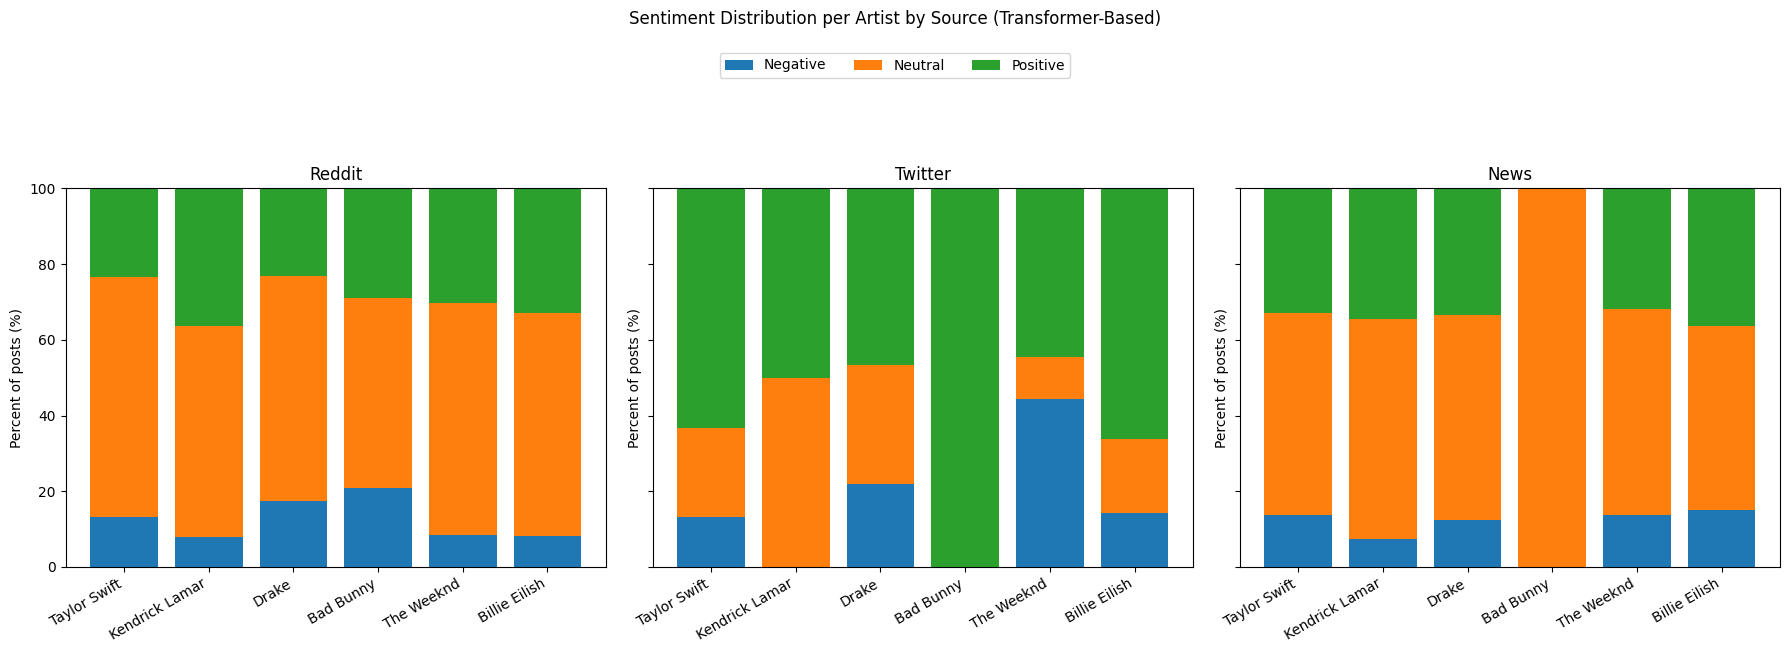

In [5]:
# plot stacked bar chart

def plot_sentiment_side_by_side(
    artist_df_scored,
    sentiment_col="sentiment_label_model",
    source_col="source",
    artist_col="primary_artist",
):
    artists = [
        "Taylor Swift",
        "Kendrick Lamar",
        "Drake",
        "Bad Bunny",
        "The Weeknd",
        "Billie Eilish",
    ]

    sentiments = ["negative", "neutral", "positive"]
    sources = ["reddit", "twitter", "news"]

    # Count source × artist × sentiment
    counts = (
        artist_df_scored
        .groupby([source_col, artist_col, sentiment_col])
        .size()
        .rename("n")
        .reset_index()
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for ax, src in zip(axes, sources):
        src_counts = counts[counts[source_col] == src]

        pivot = (
            src_counts
            .pivot_table(
                index=artist_col,
                columns=sentiment_col,
                values="n",
                aggfunc="sum",
                fill_value=0
            )
            .reindex(artists)
        )

        # Ensure all sentiment columns exist
        for s in sentiments:
            if s not in pivot.columns:
                pivot[s] = 0

        pivot = pivot[sentiments]

        # Convert to percentages per artist
        totals = pivot.sum(axis=1).replace(0, np.nan)
        pct = (pivot.div(totals, axis=0) * 100).fillna(0)

        x = np.arange(len(artists))
        neg = pct["negative"].values
        neu = pct["neutral"].values
        pos = pct["positive"].values

        ax.bar(x, neg, label="Negative")
        ax.bar(x, neu, bottom=neg, label="Neutral")
        ax.bar(x, pos, bottom=neg + neu, label="Positive")

        ax.set_title(src.title())
        ax.set_xticks(x)
        ax.set_xticklabels(artists, rotation=30, ha="right")
        ax.set_ylim(0, 100)
        ax.set_ylabel("Percent of posts (%)")

    fig.suptitle(
        "Sentiment Distribution per Artist by Source (Transformer-Based)",
        y=1.08
    )

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=3,
        bbox_to_anchor=(0.5, 1.02)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.90])
    plt.show()

plot_sentiment_side_by_side(artist_df_scored)


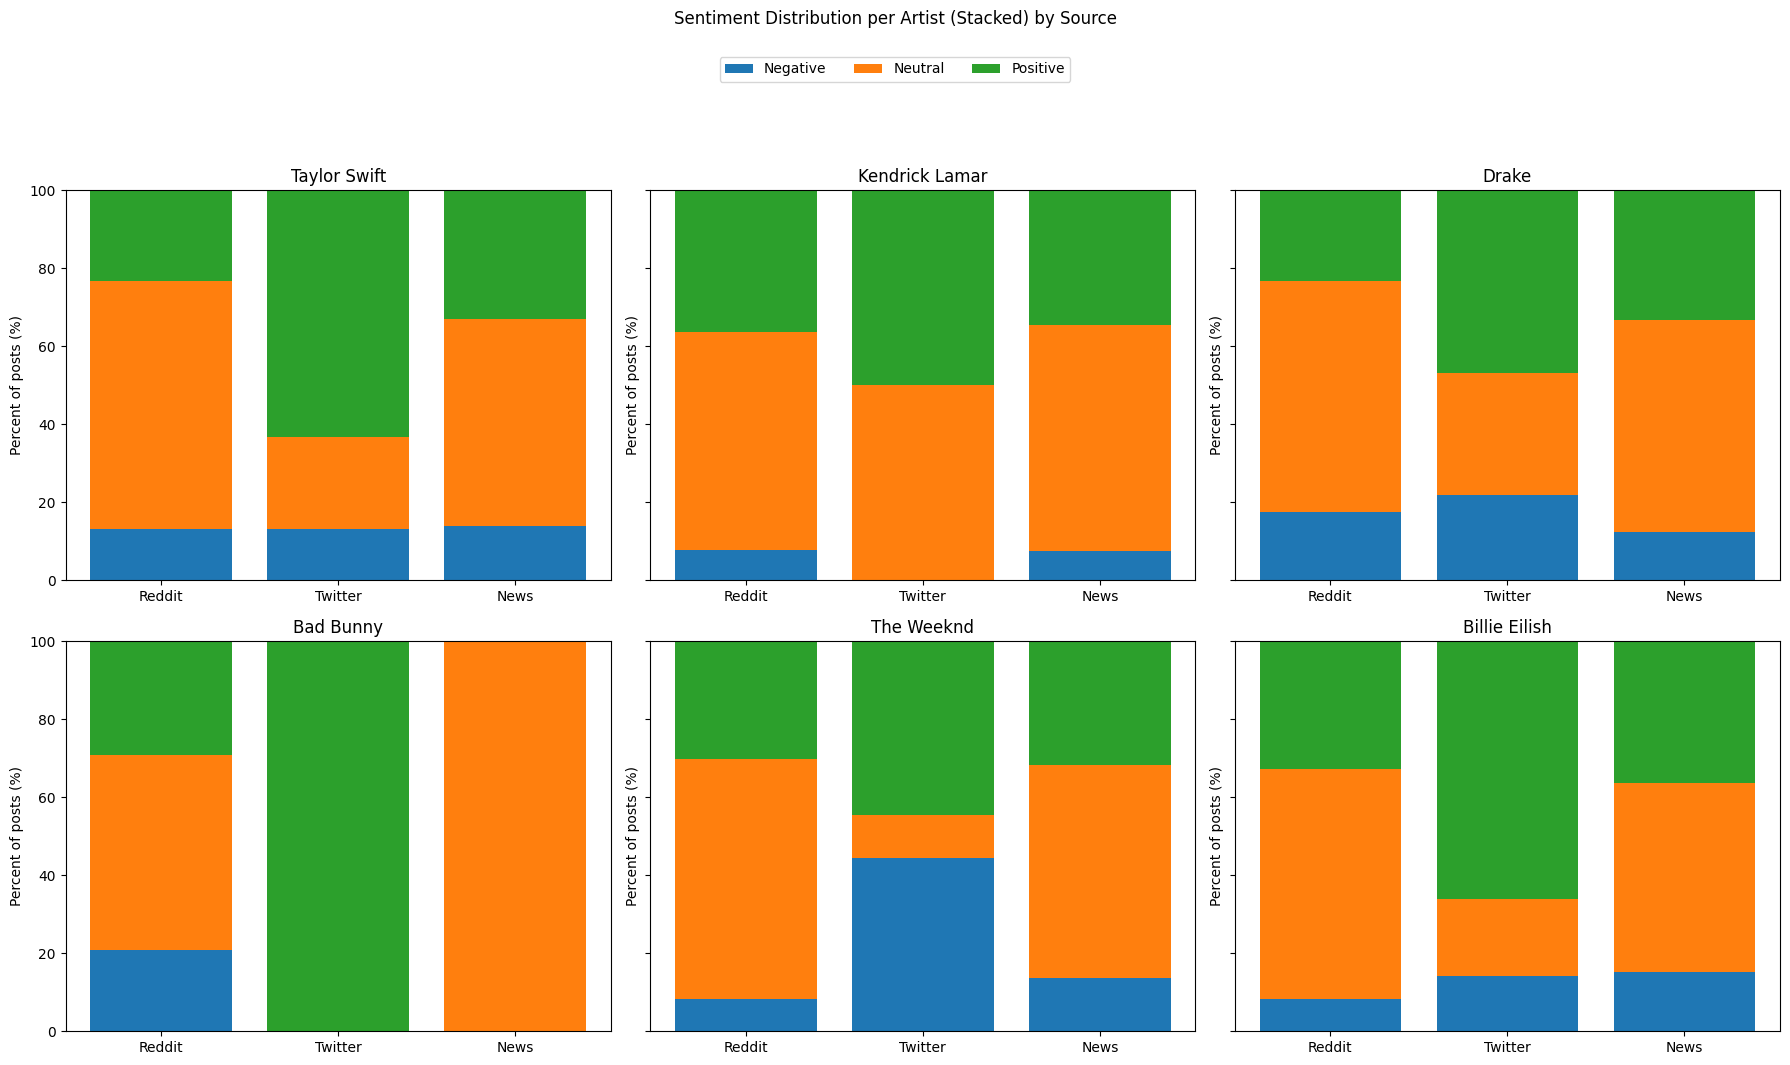

In [15]:
def plot_sentiment_per_artist_then_source(
    artist_df_scored,
    sentiment_col="sentiment_label_model",
    source_col="source",
    artist_col="primary_artist",
):
    artists = [
        "Taylor Swift",
        "Kendrick Lamar",
        "Drake",
        "Bad Bunny",
        "The Weeknd",
        "Billie Eilish",
    ]
    sentiments = ["negative", "neutral", "positive"]
    sources = ["reddit", "twitter", "news"]

    counts = (
        artist_df_scored
        .groupby([artist_col, source_col, sentiment_col])
        .size()
        .rename("n")
        .reset_index()
    )

    pivot = (
        counts
        .pivot_table(
            index=[artist_col, source_col],
            columns=sentiment_col,
            values="n",
            aggfunc="sum",
            fill_value=0
        )
    )

    # Ensure all sentiment columns exist
    for s in sentiments:
        if s not in pivot.columns:
            pivot[s] = 0
    pivot = pivot[sentiments]

    # Ensure all (artist, source) combinations exist (so missing sources show as 0)
    full_index = pd.MultiIndex.from_product([artists, sources], names=[artist_col, source_col])
    pivot = pivot.reindex(full_index, fill_value=0)

    # Convert to percentages within each (artist, source)
    totals = pivot.sum(axis=1).replace(0, np.nan)
    pct = (pivot.div(totals, axis=0) * 100).fillna(0)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)
    axes = axes.flatten()

    for ax, artist in zip(axes, artists):
        artist_pct = pct.loc[artist]  # index = source, cols = sentiments

        x = np.arange(len(sources))
        neg = artist_pct["negative"].values
        neu = artist_pct["neutral"].values
        pos = artist_pct["positive"].values

        ax.bar(x, neg, label="Negative")
        ax.bar(x, neu, bottom=neg, label="Neutral")
        ax.bar(x, pos, bottom=neg + neu, label="Positive")

        ax.set_title(artist)
        ax.set_xticks(x)
        ax.set_xticklabels([s.title() for s in sources], rotation=0)
        ax.set_ylim(0, 100)
        ax.set_ylabel("Percent of posts (%)")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))

    fig.suptitle("Sentiment Distribution per Artist (Stacked) by Source", y=1.06)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# call it
plot_sentiment_per_artist_then_source(artist_df_scored)


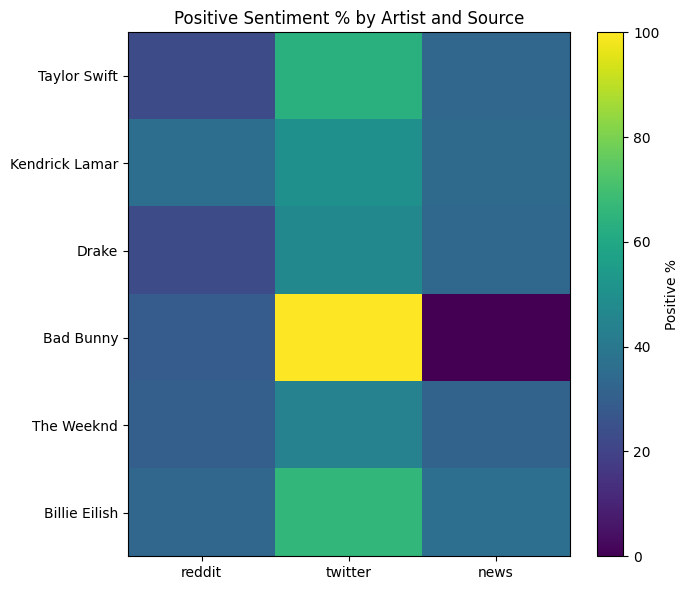

In [16]:
# heatmap visulization

def heatmap_sentiment_by_artist_source(
    artist_df_scored,
    sentiment_col="sentiment_label_model",
    focus_sentiment="positive",
    artists=None,
    sources=None,
):
    if artists is None:
        artists = [
            "Taylor Swift",
            "Kendrick Lamar",
            "Drake",
            "Bad Bunny",
            "The Weeknd",
            "Billie Eilish",
        ]
    if sources is None:
        sources = ["reddit", "twitter", "news"]

    # counts per (artist, source, sentiment)
    counts = (
        artist_df_scored
        .groupby(["primary_artist", "source", sentiment_col])
        .size()
        .rename("n")
        .reset_index()
    )

    pivot_counts = (
        counts.pivot_table(
            index=["primary_artist", "source"],
            columns=sentiment_col,
            values="n",
            fill_value=0,
            aggfunc="sum"
        )
    )

    for s in ["negative", "neutral", "positive"]:
        if s not in pivot_counts.columns:
            pivot_counts[s] = 0

    totals = pivot_counts[["negative", "neutral", "positive"]].sum(axis=1).replace(0, np.nan)
    pct = pivot_counts[["negative", "neutral", "positive"]].div(totals, axis=0) * 100
    pct = pct.fillna(0)

    mat = (
        pct[focus_sentiment]
        .unstack("source")
        .reindex(index=artists, columns=sources)
        .fillna(0)
    )

    # plot
    plt.figure(figsize=(7, 6))
    im = plt.imshow(mat.values, aspect="auto")  # no explicit colors set

    plt.title(f"{focus_sentiment.title()} Sentiment % by Artist and Source")
    plt.xticks(range(len(sources)), sources)
    plt.yticks(range(len(artists)), artists)

    cbar = plt.colorbar(im)
    cbar.set_label(f"{focus_sentiment.title()} %")

    plt.tight_layout()
    plt.show()


heatmap_sentiment_by_artist_source(artist_df_scored, focus_sentiment="positive")


In [17]:
# rag creation and embeddings

def _build_artist_patterns(artists_and_aliases: dict) -> dict:
    def alias_to_pattern(alias: str) -> str:
        parts = re.split(r"\s+", alias.strip().lower())
        return r"\b" + r"(?:\W+)".join(map(re.escape, parts)) + r"\b"

    patterns = {}
    for artist, aliases in artists_and_aliases.items():
        aliases = sorted(set(aliases), key=len, reverse=True)
        patt = "|".join(alias_to_pattern(a) for a in aliases)
        patterns[artist] = re.compile(patt, flags=re.IGNORECASE)
    return patterns

# build faiss index for rag using artist_df_scored using sentence transformers
# reutrns faiss_index, metadata_df, and embedder
def build_faiss_index_from_artist_df(
    artist_df_scored: pd.DataFrame,
    embedding_model_name: str = "sentence-transformers/all-mpnet-base-v2",
    batch_size: int = 64,
    normalize: bool = True,
) -> tuple[faiss.Index, pd.DataFrame, SentenceTransformer]:

    df = artist_df_scored.copy().reset_index(drop=True)

    def make_rag_text(row) -> str:
        src = str(row.get("source", "")).lower()
        text = str(row.get("text", "")).strip()

        if src == "news":
            title = str(row.get("title", "")).strip()
            if title and title.lower() != "nan":
                return f"{title}\n{text}".strip()

        return text

    df["rag_text"] = df.apply(make_rag_text, axis=1)

    # Drop empty rag_text
    df = df[df["rag_text"].astype(str).str.strip().ne("")].reset_index(drop=True)
    rag_texts = df["rag_text"].tolist()

    meta_cols = [
        "source",
        "id",
        "date",
        "category",
        "title",
        "url",
        "author",
        "primary_artist",
        "artists_matched",
        "sentiment_label_model",
        "sentiment_score_model",
        "sentiment_confidence_model",
        "rag_text",
    ]
    meta_cols = [c for c in meta_cols if c in df.columns]

    metadata_df = df[meta_cols].copy()
    metadata_df.insert(0, "vector_id", np.arange(len(metadata_df), dtype=int))


    # Ensure artists_matched is a list (for safe filtering later)
    if "artists_matched" in metadata_df.columns:
        metadata_df["artists_matched"] = metadata_df["artists_matched"].apply(
            lambda x: x if isinstance(x, list) else ([] if pd.isna(x) else [str(x)])
        )

    # 3) Embed + build FAISS index
    embedder = SentenceTransformer(embedding_model_name)

    doc_vectors = embedder.encode(
        rag_texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=normalize,
    ).astype("float32")

    dim = doc_vectors.shape[1]
    if normalize:
        faiss_index = faiss.IndexFlatIP(dim)
    else:
        faiss_index = faiss.IndexFlatL2(dim)

    faiss_index.add(doc_vectors)

    print(f"Built FAISS index with {faiss_index.ntotal} documents (dim={dim})")

    return faiss_index, metadata_df, embedder

faiss_index, metadata_df, embedder = build_faiss_index_from_artist_df(
    artist_df_scored,
    embedding_model_name="sentence-transformers/all-mpnet-base-v2",
    batch_size=64,
    normalize=True
)

metadata_df.head()


Batches:   0%|          | 0/133 [00:00<?, ?it/s]

Built FAISS index with 8490 documents (dim=768)


,vector_id,source,id,date,category,title,url,author,primary_artist,artists_matched,sentiment_label_model,sentiment_score_model,sentiment_confidence_model,rag_text
0,0,twitter,1553516207,2009-04-18 14:28:40+00:00,<NA>,<NA>,<NA>,HollandMarielle,Drake,[Drake],negative,-0.883720,0.896848,"I must admit, i'm a little pissed ppl are star..."
1,1,twitter,1553554974,2009-04-18 14:35:00+00:00,<NA>,<NA>,<NA>,HollandMarielle,Drake,[Drake],negative,-0.864222,0.880006,"I must admit, i'm a little pissed ppl r starti..."
2,2,twitter,1553946455,2009-04-18 15:38:47+00:00,<NA>,<NA>,<NA>,laceybenz,Drake,[Drake],negative,-0.737178,0.778096,jealous of all the IA festivities i'm missing ...
3,3,twitter,1557796970,2009-04-19 06:02:38+00:00,<NA>,<NA>,<NA>,lou_lalala,Drake,[Drake],positive,0.431828,0.481288,"just kicking back watching Drake &amp; Josh, r..."
4,4,twitter,1558040401,2009-04-19 07:02:39+00:00,<NA>,<NA>,<NA>,akash_palia,Taylor Swift,[Taylor Swift],negative,-0.845970,0.861193,have a big time crush on taylor swift but she ...


In [8]:
# tie together RAG and LLM

# returns a dataframe with the top k retrieved rows
def retrieve_evidence(
    query: str,
    faiss_index,
    metadata_df: pd.DataFrame,
    embedder,
    top_k: int = 10,
    k_search: int = 80,
    source: str | None = None,
    artist: str | None = None,
    sentiment: str | None = None,
    sentiment_score_lt: float | None = None,
    min_conf: float | None = None,
):

    # Embed query (normalized embeddings assumed if you built index with normalize=True)
    qvec = embedder.encode([query], normalize_embeddings=True, convert_to_numpy=True).astype("float32")

    # Search
    scores, ids = faiss_index.search(qvec, k_search)
    scores = scores[0]
    ids = ids[0]

    # Pull candidate metadata
    cand = metadata_df.set_index("vector_id").loc[ids].copy()
    cand = cand.reset_index()  # brings vector_id back
    cand["retrieval_score"] = scores

    # Apply filters
    if source is not None and "source" in cand.columns:
        cand = cand[cand["source"].str.lower() == source.lower()]

    if artist is not None:
        if "primary_artist" in cand.columns:
            cand = cand[cand["primary_artist"] == artist]
        elif "artists_matched" in cand.columns:
            cand = cand[cand["artists_matched"].apply(lambda xs: artist in xs if isinstance(xs, list) else False)]

    if sentiment is not None and "sentiment_label_model" in cand.columns:
        cand = cand[cand["sentiment_label_model"] == sentiment]

    if sentiment_score_lt is not None and "sentiment_score_model" in cand.columns:
        cand = cand[pd.to_numeric(cand["sentiment_score_model"], errors="coerce") < sentiment_score_lt]

    if min_conf is not None and "sentiment_confidence_model" in cand.columns:
        cand = cand[pd.to_numeric(cand["sentiment_confidence_model"], errors="coerce") >= min_conf]

    # Sort by retrieval score desc and keep top_k
    cand = cand.sort_values("retrieval_score", ascending=False).head(top_k)

    return cand


# rerank for relevence using cross-encoder
# returns top k with a rerank score
def rerank_evidence(
    query: str,
    evidence_df: pd.DataFrame,
    text_col: str = "rag_text",
    reranker_name: str = "cross-encoder/ms-marco-MiniLM-L-6-v2",
    top_k: int = 10,
):

    if text_col not in evidence_df.columns:
        raise ValueError(f"Expected '{text_col}' in evidence_df columns. Found: {evidence_df.columns.tolist()}")

    reranker = CrossEncoder(reranker_name)

    pairs = [(query, t) for t in evidence_df[text_col].astype(str).tolist()]
    scores = reranker.predict(pairs)

    out = evidence_df.copy()
    out["rerank_score"] = scores
    out = out.sort_values("rerank_score", ascending=False).head(top_k)
    return out

def build_evidence_packet(evidence_df: pd.DataFrame, text_col: str = "rag_text") -> str:
    lines = []
    for i, row in enumerate(evidence_df.itertuples(index=False), start=1):
        text = getattr(row, text_col) if hasattr(row, text_col) else ""
        source = getattr(row, "source", "unknown") if hasattr(row, "source") else "unknown"
        artist = getattr(row, "primary_artist", "unknown") if hasattr(row, "primary_artist") else "unknown"
        sent = getattr(row, "sentiment_label_model", "unknown") if hasattr(row, "sentiment_label_model") else "unknown"
        lines.append(f"[{i}] (source={source}, artist={artist}, sentiment={sent}) {str(text).strip()}")
    return "\n\n".join(lines)


def build_rag_prompt(question: str, evidence_packet: str) -> str:
    return f"""
    You are answering questions about public perception of music artists.

    CRITICAL RULES:
    - Use ONLY the EVIDENCE provided below.
    - Do NOT use outside knowledge or assumptions.
    - If the evidence is insufficient to answer the question, explicitly say:
      "The available evidence is insufficient to answer this question."

    RESPONSE REQUIREMENTS:
    1. Provide a concise answer (3–6 sentences).
    2. Include AT LEAST 3 citations using the format [1], [2], [3].
    3. Include AT LEAST 2 short quoted phrases (in quotation marks) taken directly from the evidence.
    4. Every claim must be supported by one or more citations.
    5. If evidence is conflicting, explicitly note the conflict and cite both sides.
    6. Do NOT cite anything that is not present in the evidence.

    QUESTION:
    {question}

    EVIDENCE:
    {evidence_packet}
    """


# passing it through LLM
def answer_with_gemini(question: str, prompt: str):
    genai.configure(api_key=userdata.get("GEMINI_API_KEY"))
    model = genai.GenerativeModel("gemini-2.5-flash")
    resp = model.generate_content(prompt)
    return resp.text

def run_rag_query(
    question: str,
    faiss_index,
    metadata_df,
    embedder,
    filters: dict | None = None,
    use_rerank: bool = True,
    retrieve_top_k: int = 50,
    rerank_top_k: int = 10,
    k_search: int = 120,
):
    filters = filters or {}

    # Retrieve candidates
    evidence = retrieve_evidence(
        query=question,
        faiss_index=faiss_index,
        metadata_df=metadata_df,
        embedder=embedder,
        top_k=retrieve_top_k,
        k_search=k_search,
        **filters
    )

    # re rank
    if use_rerank:
        evidence = rerank_evidence(
            query=question,
            evidence_df=evidence,
            top_k=rerank_top_k
        )
    else:
        evidence = evidence.head(rerank_top_k)

    # Build prompt
    evidence_packet = build_evidence_packet(evidence)
    prompt = build_rag_prompt(question, evidence_packet)

    # LLM answer
    answer = answer_with_gemini(question, prompt)

    return answer, evidence, prompt

In [9]:
# evaluating RAG responses with deep eval

from deepeval.test_case import LLMTestCase
from deepeval.metrics import (
    AnswerRelevancyMetric,
    FaithfulnessMetric,
    ContextualRelevancyMetric,
)
from deepeval import evaluate
from deepeval.models import GeminiModel
import os


def _safe_get(obj, name, default=None):
    return getattr(obj, name, default)


def evaluate_rag_response(
    question: str,
    answer: str,
    evidence_df,
    text_col: str = "rag_text",
    judge_model: str = "gemini-2.5-flash",
    threshold: float = 0.6,
):
    # contexts from your evidence dataframe
    contexts = evidence_df[text_col].fillna("").astype(str).tolist()

    test_case = LLMTestCase(
        input=question,
        actual_output=answer,
        retrieval_context=contexts,
    )

    judge = GeminiModel(
        model=judge_model,
        api_key=userdata.get("GEMINI_API_KEY"),
    )

    metrics = [
        AnswerRelevancyMetric(threshold=threshold, model=judge),
        FaithfulnessMetric(threshold=threshold, model=judge),
        ContextualRelevancyMetric(threshold=threshold, model=judge),
    ]

    evaluate([test_case], metrics)

    out = {}
    for m in metrics:
        score = _safe_get(m, "score", None)
        out[m.__class__.__name__] = {
            "score": score,
            "passed": (score is not None and score >= threshold),
            "reason": _safe_get(m, "reason", None),
        }
    return out



# Test Prompts

In [10]:
# test prompt 1

question = "What narratives dominate positive comments of Taylor Swift?"

answer, evidence, prompt = run_rag_query(
    question=question,
    faiss_index=faiss_index,
    metadata_df=metadata_df,
    embedder=embedder,
    filters={
        "artist": "Taylor Swift",
        "sentiment": "positive"
    },
    use_rerank=True,
    retrieve_top_k=80,
    rerank_top_k=8,
    k_search=200
)

print(answer)
display(evidence[["source", "title", "sentiment_label_model", "rag_text"]])

print("\n \n")

scores = evaluate_rag_response(
    question=question,
    answer=answer,
    evidence_df=evidence,
)

scores

Positive comments about Taylor Swift frequently emphasize her artistic talent and commercial achievements, with Dolly Parton praising her as "a great writer — with or without anybody" [2]. Her song "Anti-Hero" is noted for "soaring to become one her biggest hits in years" [3]. Narratives also highlight her significant impact beyond music, as research suggests her music positively impacts mental health [1], and her victories are described as feeling "bigger than herself" [5]. Furthermore, her ambition is recognized, with Lana Del Rey noting Swift "wants it more than anyone" [8], and her fanbase is commended as "by far the nicest ones" [7].


,source,title,sentiment_label_model,rag_text
124,reddit,<NA>,positive,research has found that taylor swift’s music p...
182,reddit,<NA>,positive,dolly parton praises taylor swift amid damon a...
137,reddit,<NA>,positive,taylor swift’s ‘anti-hero’ is soaring to becom...
167,reddit,<NA>,positive,taylor swift already made her attitude toward ...
6,reddit,<NA>,positive,"""feels bigger than herself"": the importance of..."
162,reddit,<NA>,positive,travis kelce’s mom donna is asked what her fav...
76,reddit,<NA>,positive,about the taylor swift fandom… i just want to ...
176,reddit,<NA>,positive,lana del rey on taylor swift’s success: “she’s...


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

Output()

INFO:deepeval.evaluate.execute:in _a_execute_llm_test_cases




Metrics Summary

  - ✅ Answer Relevancy (score: 0.9, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 0.90 because while the output largely addressed narratives dominating positive comments about Taylor Swift, it included a statement describing her fanbase, which was not directly relevant to narratives about Taylor Swift herself. This minor irrelevancy prevented a perfect score, but the majority of the content was highly relevant., error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 1.00 because the actual output is perfectly aligned with the retrieval context! Great job!, error: None)
  - ❌ Contextual Relevancy (score: 0.35294117647058826, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 0.35 because while some statements like 'research has found that taylor swift’s music positively impacts mental he

⚠ WARNING: No hyperparameters logged.
» ]8;id=858183;https://deepeval.com/docs/evaluation-prompts\Log hyperparameters]8;;\ to attribute prompts and models to your test runs.

================================================================================

✓ Evaluation completed 🎉! (time taken: 27.24s | token cost: 0.0 USD)
» Test Results (1 total tests):
   » Pass Rate: 0.0% | Passed: 0 | Failed: 1

 ================================================================================ 

» Want to share evals with your team, or a place for your test cases to live? ❤️ 🏡
  » Run 'deepeval view' to analyze and save testing results on Confident AI.

{'AnswerRelevancyMetric': {'score': None, 'passed': False, 'reason': None},
 'FaithfulnessMetric': {'score': None, 'passed': False, 'reason': None},
 'ContextualRelevancyMetric': {'score': None, 'passed': False, 'reason': None}}

In [11]:
# test prompt 2

question = "How does public sentiment toward Drake differ between Reddit and Twitter?"

answer, evidence, prompt = run_rag_query(
    question=question,
    faiss_index=faiss_index,
    metadata_df=metadata_df,
    embedder=embedder,
    filters={"artist": "Drake"},
    use_rerank=True,
    retrieve_top_k=80,
    rerank_top_k=8,
    k_search=200
)

print(answer)
display(evidence[["source", "title", "sentiment_label_model", "rag_text"]])

print("\n \n")

scores = evaluate_rag_response(
    question=question,
    answer=answer,
    evidence_df=evidence,
)

scores

Public sentiment toward Drake differs notably between Reddit and Twitter, with Reddit expressing more explicitly negative views. On Twitter, discussions are often neutral, erupting with opinions on events like album releases or traffic issues [1, 3]. However, there was also positive sentiment observed when "Twitter Got To Work After Drake And Rihanna's Kiss," suggesting "He's got love on the brain" [2]. In contrast, Reddit content explicitly criticizes Drake, with posts claiming "for drake, the misogyny is the message" and reporting that he "sparked backlash after he posted a “disturbing” and “creepy” photo" [5, 6]. While Twitter also included neutral mentions of "Mean Tweets" or fan inquiries [4, 8], Reddit's direct sentiment about Drake leans towards strong negativity, contrasting with Twitter's more varied and generally less critical tone.


,source,title,sentiment_label_model,rag_text
25,news,Twitter Erupts With Opinions After Beyoncé Dr...,neutral,Twitter Erupts With Opinions After Beyoncé Dr...
37,news,Twitter Got To Work After Drake And Rihanna's ...,positive,Twitter Got To Work After Drake And Rihanna's ...
76,news,Twitter Knows The Real Reasons Drake Was Stuck...,neutral,Twitter Knows The Real Reasons Drake Was Stuck...
58,news,'Mean Tweets' Goes From 0 To 100 Real Quick Wi...,neutral,'Mean Tweets' Goes From 0 To 100 Real Quick Wi...
21,reddit,<NA>,negative,"for drake, the misogyny is the message"
9,reddit,<NA>,negative,drake has sparked backlash after he posted a “...
60,reddit,<NA>,neutral,ariana grande hopes kanye and drake's twitter ...
61,twitter,<NA>,neutral,@bigvon omg I didn't kno u where on this late!...


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

Output()

INFO:deepeval.evaluate.execute:in _a_execute_llm_test_cases




Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 1.00 because the output perfectly addressed the input without any irrelevant statements. Great job!, error: None)
  - ❌ Faithfulness (score: 0.5714285714285714, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 0.57 because the actual output incorrectly attributes claims about Drake's misogyny and backlash over a photo to Reddit, which is not mentioned in the retrieval context. Additionally, it mischaracterizes 'Mean Tweets' as neutral and mentions 'fan inquiries regarding Drake' which are not present in the context., error: None)
  - ❌ Contextual Relevancy (score: 0.0, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 0.00 because the retrieval context is entirely irrelevant to the input, 'How does public sentiment toward Drake differ between 

⚠ WARNING: No hyperparameters logged.
» ]8;id=537417;https://deepeval.com/docs/evaluation-prompts\Log hyperparameters]8;;\ to attribute prompts and models to your test runs.

================================================================================

✓ Evaluation completed 🎉! (time taken: 23.43s | token cost: 0.0 USD)
» Test Results (1 total tests):
   » Pass Rate: 0.0% | Passed: 0 | Failed: 1

 ================================================================================ 

» Want to share evals with your team, or a place for your test cases to live? ❤️ 🏡
  » Run 'deepeval view' to analyze and save testing results on Confident AI.

{'AnswerRelevancyMetric': {'score': None, 'passed': False, 'reason': None},
 'FaithfulnessMetric': {'score': None, 'passed': False, 'reason': None},
 'ContextualRelevancyMetric': {'score': None, 'passed': False, 'reason': None}}

In [12]:
question = "What recurring themes appear in discussions of Billie Eilish’s public image?"

answer, evidence, prompt = run_rag_query(
    question=question,
    faiss_index=faiss_index,
    metadata_df=metadata_df,
    embedder=embedder,
    filters={"artist": "Billie Eilish"},
    use_rerank=True,
    retrieve_top_k=80,
    rerank_top_k=8,
    k_search=200
)

print(answer)
display(evidence[["source", "title", "sentiment_label_model", "rag_text"]])

print("\n \n")

scores = evaluate_rag_response(
    question=question,
    answer=answer,
    evidence_df=evidence,
)

scores

Discussions of Billie Eilish's public image frequently revolve around themes of womanhood, often describing it as "'such a war, forever'" [1], [2], [3]. Her evolving self-perception and vulnerability are also prominent topics, as seen in her feeling "incredibly unlovable" [4], contrasted with later expressions of liking "who i am a lot at this point" [8]. The impact of fame is another recurring theme, exploring her "complicated relationship with the internet" and "the price of fame," alongside the emergence of a "new billie" [6]. The pursuit of happiness is also highlighted in public conversations surrounding her [5].


,source,title,sentiment_label_model,rag_text
41,reddit,<NA>,neutral,billie eilish was made for this: ‘being a woma...
42,reddit,<NA>,neutral,billie eilish was made for this: ‘being a woma...
43,reddit,<NA>,neutral,billie eilish was made for this: ‘being a woma...
74,reddit,<NA>,negative,"billie eilish: 'nobody is attracted to me, i f..."
10,reddit,<NA>,positive,billie eilish and the pursuit of happiness : r...
7,reddit,<NA>,neutral,billie eilish on her complicated relationship ...
51,reddit,<NA>,neutral,billie eilish talking about a scene from ‘miss...
0,reddit,<NA>,positive,“i like who i am a lot at this point”: the ris...


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

Output()

INFO:deepeval.evaluate.execute:in _a_execute_llm_test_cases




Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 1.00 because the output is perfectly relevant and directly addresses the input without any irrelevant statements. Great job!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 1.00 because the actual output is perfectly aligned with the retrieval context. Great job!, error: None)
  - ✅ Contextual Relevancy (score: 0.6428571428571429, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 0.64 because while statements like "'being a woman is just such a war, forever'", "billie eilish: 'nobody is attracted to me, i feel incredibly unlovable'", "billie eilish on her complicated relationship with the internet", "the price of fame", and "the “new billie”" are relevant to recurring themes in discussions of Bill

⚠ WARNING: No hyperparameters logged.
» ]8;id=787936;https://deepeval.com/docs/evaluation-prompts\Log hyperparameters]8;;\ to attribute prompts and models to your test runs.

================================================================================

✓ Evaluation completed 🎉! (time taken: 18.0s | token cost: 0.0 USD)
» Test Results (1 total tests):
   » Pass Rate: 100.0% | Passed: 1 | Failed: 0

 ================================================================================ 

» Want to share evals with your team, or a place for your test cases to live? ❤️ 🏡
  » Run 'deepeval view' to analyze and save testing results on Confident AI.

{'AnswerRelevancyMetric': {'score': None, 'passed': False, 'reason': None},
 'FaithfulnessMetric': {'score': None, 'passed': False, 'reason': None},
 'ContextualRelevancyMetric': {'score': None, 'passed': False, 'reason': None}}

In [13]:
question = "Which artist receives more polarized reactions: Taylor Swift or Billie Eilish?"

answer, evidence, prompt = run_rag_query(
    question=question,
    faiss_index=faiss_index,
    metadata_df=metadata_df,
    embedder=embedder,
    use_rerank=True,
    retrieve_top_k=80,
    rerank_top_k=8,
    k_search=200
)

print(answer)
display(evidence[["source", "title", "sentiment_label_model", "rag_text"]])

print("\n \n")

scores = evaluate_rag_response(
    question=question,
    answer=answer,
    evidence_df=evidence,
)

scores

Based on the available evidence, Billie Eilish appears to receive more polarized reactions than Taylor Swift. Billie Eilish garnered significant positive acclaim, being named "apple music's artist of the year" and hailed as "'a voice of her generation'" [7]. Simultaneously, she faced "huge 'targeting taylor swift' backlash" which required her to clarify the situation [6], and was central to a debate after Kanye West was described as "dragging billie eilish" [3]. While Taylor Swift is referenced in connection to an "infamous taylor swift feud" [3] and debates on misogyny [5], indicating controversy, the provided evidence does not explicitly contain examples of strong positive public sentiment for her. Therefore, Billie Eilish shows a more complete spectrum of strong positive and negative reactions in the evidence.


,source,title,sentiment_label_model,rag_text
44,reddit,<NA>,neutral,teens react to billie eilish reacts to teens r...
68,reddit,<NA>,neutral,billie eilish (taylor’s version)
29,reddit,<NA>,negative,kanye west dragging billie eilish sparked a de...
27,reddit,<NA>,neutral,taylor swift vs. billie eilish - you made me d...
14,reddit,<NA>,neutral,kanye west dragging billie eilish sparks debat...
0,reddit,<NA>,neutral,billie eilish sets record straight after huge ...
25,reddit,<NA>,positive,billie eilish is apple music's artist of the y...
1,reddit,<NA>,neutral,billie eilish vs taylor swift? who does what b...


✨ You're running DeepEval's latest Answer Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gemini-2.5-flash (Gemini), strict=False, 
async_mode=True)...

Output()

INFO:deepeval.evaluate.execute:in _a_execute_llm_test_cases




Metrics Summary

  - ✅ Answer Relevancy (score: 1.0, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 1.00 because the output is perfectly relevant to the input, with no irrelevant statements whatsoever. Great job!, error: None)
  - ✅ Faithfulness (score: 1.0, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 1.00 because the actual output is perfectly aligned with the retrieval context! Great job!, error: None)
  - ✅ Contextual Relevancy (score: 0.6875, threshold: 0.6, strict: False, evaluation model: gemini-2.5-flash (Gemini), reason: The score is 0.69 because while the context contains relevant comparisons like "taylor swift vs. billie eilish" and mentions debates involving both artists such as "kanye west dragging billie eilish sparked a debate about his treatment of young women after people compared it with the infamous taylor swift feud", it lacks direct information about *their* pola

⚠ WARNING: No hyperparameters logged.
» ]8;id=541626;https://deepeval.com/docs/evaluation-prompts\Log hyperparameters]8;;\ to attribute prompts and models to your test runs.

================================================================================

✓ Evaluation completed 🎉! (time taken: 20.06s | token cost: 0.0 USD)
» Test Results (1 total tests):
   » Pass Rate: 100.0% | Passed: 1 | Failed: 0

 ================================================================================ 

» Want to share evals with your team, or a place for your test cases to live? ❤️ 🏡
  » Run 'deepeval view' to analyze and save testing results on Confident AI.

{'AnswerRelevancyMetric': {'score': None, 'passed': False, 'reason': None},
 'FaithfulnessMetric': {'score': None, 'passed': False, 'reason': None},
 'ContextualRelevancyMetric': {'score': None, 'passed': False, 'reason': None}}